# Agent Speed Calibration

The aim of this notebook is to estimate the value of model parameters pertaining to pedestrian agent speed.
These specifically focus on:
* `speed_min`, i.e. the minimum speed of the pedestrian agents,
* `speed_mean`, i.e. the mean speed of the pedestrian agents,
* `speed_std`, i.e. the standard deviation of the speeds of the pedestrian agents.

This is achieved through some basic analysis of the data pertaining to the paths of the pedestrians 

## Imports

First of all, we import the packages that we plan to use of this analysis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

%matplotlib inline

## Paths and Directories

Next, we note the relative path to the data that we plan to use:

In [2]:
combined_frames_path = '../data/outputs/combined_frames.csv'

## Functions

Here, I have defined some functions that will be useful later in the analysis:

In [3]:
def get_distance(x0, y0, x1, y1):
    x_diff = x1 - x0
    y_diff = y1 - y0
    return sqrt(x_diff*x_diff + y_diff*y_diff)

In [4]:
def get_speed_profile(x_coordinates, y_coordinates):
    assert len(x_coordinates) == len(y_coordinates)
    
    FRAMES_PER_SECOND = 25
    PIXELS_PER_METRE = 14
    ratio = FRAMES_PER_SECOND / PIXELS_PER_METRE
    
    total_distance = get_distance(x_coordinates[0], y_coordinates[0],
                                  x_coordinates[-1], y_coordinates[-1])
    average_speed = ratio * total_distance / (len(x_coordinates) - 1)
        
    return average_speed

## Analysis

We start our analysis by reading in the data pertaining to the paths of pedestrians across the concourse:

In [5]:
frames_data = pd.read_csv(combined_frames_path)
frames_data.head()

,frame,pedestrianID,x,y
0,5327,245,563.110625,676.817906
1,5327,246,534.003343,631.251565
2,462,198,49.431612,296.911898
3,462,199,539.377299,88.443098
4,462,208,486.787285,560.910907


Above, we can see that this dataset is made up fo observations pertaining to 4 columns:
* `frame`, i.e. the frame in which the observation was captured,
* `pedestrianID` i.e. the unique pedestrian that the observation relates to,
* `x`, i.e. the $x$-coordinate of the pedestrian within the concourse in the frame,
* `y`, i.e. the $y$-coordinate of the pedestrian within the concourse in the frame.

The aim of this analysis is to use this data to ascertain values for a collection of speed parameters - namely `speed_min` (the minimum pedestrian agent speed), `speed_mean` (the mean pedestrian agent speed) and `speed_std` (the standard deviation of the pedestrian agent speeds).
Additionally, we would like to find out how many unique pedestrians are in our data, as this will inform how many pedestrian agents should be simulated in our model.

Using the `unique()` method, create a list of all of the unique pedestrian IDs in the `frames_data` dataframe called `pedestrian_ids`:

In [6]:
# Insert code here
# Replace None with an expression to find the unique pedestrian ids
pedestrian_ids = frames_data["pedestrianID"].unique()

How many unique pedetrian IDs are there?

In [8]:
# Insert code here
# Find the number of unique pedestrian IDs
len(pedestrian_ids)

274

Now that we have a list of the unique pedestrian IDs, we can isolate the data pertaining to each of the pedestrians, and create trajectories of each of their journeys across the concourse, with each trajectory consisting of a series of $x$-coordinates and $y$-coordinates.

In [9]:
pedestrian_trajectories = dict()

for pid in pedestrian_ids:
    df = frames_data.loc[frames_data['pedestrianID']==pid, :]
    df = df.sort_values(by='frame')
    d = {'xs': list(df['x']),
         'ys': list(df['y'])}
    pedestrian_trajectories[pid] = d

Based on the paths pertaining to each of the pedestrians, we can now create a list of all of their average speeds.
In this case, we are calculating the average speed as
$$v_i = \frac{d_i}{t_i} $$
where $v_i$ is the average speed of the $i$th pedestrian, $d_i$ is the distance between the entry point and the exit point of the $i$th pedestrian, and $t_i$ is the number of frames between the entry of the $i$th pedestrian and their exit from the system.

In short, for each pedestrian we are calculating their speed "as the crow flies".

In [10]:
speeds = list()
for trajectory in pedestrian_trajectories.values():
    average_speed = get_speed_profile(trajectory['xs'], trajectory['ys'])
    speeds.append(average_speed)

Having calculated speeds for each of the pedestrians, we want to filter out any $0$s - there may be some pedestrians that do not move in our data.

In [11]:
# Make list of average speeds excluding 0s
speeds = [speed for speed in speeds if speed != 0]

Now that we have average speeds for our pedestrians, we are intersted in understanding their ditribution.
We can approach this by producing a KDE plot (kernel density estimate):

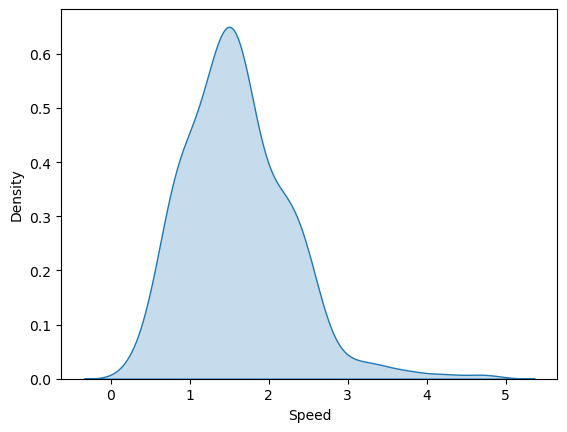

In [12]:
plt.figure()
sns.kdeplot(x=speeds, fill=True)
plt.xlabel('Speed')
plt.show()

In the literature for pedetrian dynamics, we often observe that pedetrians speeds are normally distributed; we shall assume that that assumption holds for this dataset also.
Based on this assumption, we would like to calculate the mean, standard deviation and minimum of the speeds:

In [13]:
# Insert code here
# In each case, replace None with an expression to calculate the relevant quantity
speed_mean = np.mean(speeds)
speed_std = np.std(speeds)
speed_min = np.min(speeds)

In [16]:
print(f"mean: {speed_mean} \t std: {speed_std} \t min: {speed_min}")

mean: 1.6026400144010877 	 std: 0.6642343305178545 	 min: 0.31125359137714953


Finally, we would like to check whether pedestrian speeds sampled from a normal distribution with these attributes is representative of the speeds that we observe in the data.
The first step to achieving this is to create some sample speeds by drawing sample speeds from a normal distriubtion:

In [17]:
speed_samples = np.random.normal(loc=speed_mean, scale=speed_std, size=1000)

We can then produce a plot overlaying the distribution of the speeds from the data with a histogram of speeds sampled from a normal distribution based on the parameter values that we have just found:

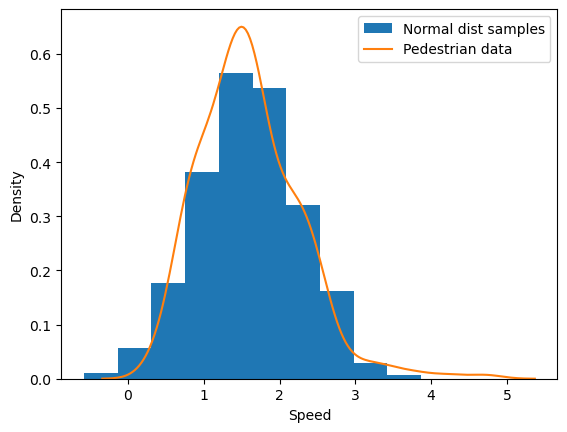

In [18]:
plt.figure()
plt.hist(speed_samples, density=True, label='Normal dist samples')
sns.kdeplot(speeds, label='Pedestrian data')
plt.xlabel('Speed')
plt.legend()
plt.show()

Hopefully we can see that the two datasets match each other in distribution (for the most part).
It is worth noting that the distribtion of speeds sampled from the normal distribution will look different for each of us given that we have drawn these values from a random distribution - if you were to compare your version of this figure with one that your neighbour produced, you would find that they looked similar but not exactly the same and this is nothing to be alarmed by.

## Closing Remarks

This notebook has contained a brief analysis of some data regarding the motion of pedestrians at Grand Central Station in New York.
By working through this notebook, you should have been able to derive values for the speed parameters that we will use for our agent-based model going into the [next notebook](./3_birth_rate_calibration.ipynb), i.e.:
* `speed_mean`
* `speed_std`
* `speed_min`

You should have also found the number of unique pedestrians, which will also be needed when running the model.

You may wish to experiment further with this data.
This could include exploring different ways to calculate the speed of the pedestrians (such as considering their instantaneous speed instead of their average speed), producing other types of visualisations, or producing animations of how the pedestrians move in around the concourse.

Otherwise, let's move on to the final notebook, where we will make use of the information that we have found here to run the model and calibrate the rate at which pedestrians enter the system.